In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import kagglehub

In [24]:
path = kagglehub.dataset_download("oussamaslmani/dyslexic")
print("Path to dataset files:", path)

Path to dataset files: /Users/asimmahmudov/.cache/kagglehub/datasets/oussamaslmani/dyslexic/versions/1


In [25]:
non_dyslexia_path = os.path.join(path, 'dyslexic', 'no')
dyslexia_path = os.path.join(path, 'dyslexic', 'yes')

In [26]:
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def reduce_noise(image, method="gaussian"):
    if method == "gaussian":
        return cv2.GaussianBlur(image, (5, 5), 0)
    elif method == "median":
        return cv2.medianBlur(image, 5)

def binarize_image(image):
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return binary_image

def resize_image(image, size=(128, 128)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

def add_padding(image, target_size=(128, 128)):
    old_size = image.shape[:2]
    delta_w = target_size[1] - old_size[1]
    delta_h = target_size[0] - old_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    color = [0, 0, 0]  # Black padding
    return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

In [27]:
def preprocess_image(image_path, size=(128, 128)):
    image = cv2.imread(image_path)
    image = convert_to_grayscale(image)
    image = reduce_noise(image, method="gaussian")
    image = binarize_image(image)
    image = resize_image(image, size=size)
    image = add_padding(image, target_size=size)
    return image

def load_and_preprocess_images(folder_path, label, size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            processed_image = preprocess_image(file_path, size=size)
            images.append(processed_image)
            labels.append(label)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    return images, labels

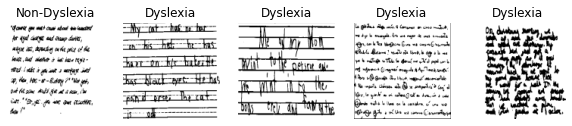

In [28]:
size = (128, 128)
non_dyslexia_images, non_dyslexia_labels = load_and_preprocess_images(non_dyslexia_path, label=0, size=size)
dyslexia_images, dyslexia_labels = load_and_preprocess_images(dyslexia_path, label=1, size=size)

images = np.array(non_dyslexia_images + dyslexia_images)
labels = np.array(non_dyslexia_labels + dyslexia_labels)

images = images / 255.0

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

def visualize_images(images, labels, classes, num=5):
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()

classes = ["Non-Dyslexia", "Dyslexia"]
visualize_images(X_train, y_train, classes, num=5)

In [29]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow(np.repeat(X_train, 3, axis=-1), y_train, batch_size=32)
val_gen = ImageDataGenerator().flow(np.repeat(X_test, 3, axis=-1), y_test, batch_size=32)

In [30]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [32]:
history = model.fit(
    np.repeat(X_train, 3, axis=-1), y_train,
    validation_data=(np.repeat(X_test, 3, axis=-1), y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6281 - loss: 0.6845 - val_accuracy: 0.8500 - val_loss: 0.4083
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - loss: 0.0597 - val_accuracy: 0.6500 - val_loss: 0.4898
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9937 - loss: 0.0448 - val_accuracy: 0.9500 - val_loss: 0.1745
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9758 - loss: 0.0525 - val_accuracy: 0.9500 - val_loss: 0.1398
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9516 - loss: 0.0760 - val_accuracy: 0.9500 - val_loss: 0.0822
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.9000 - val_loss: 0.1023
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9898 - loss: 0.0323 - val_accuracy: 0.9500 - val_loss: 0.2123
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9898 - loss: 0.0401 - val_accuracy: 0.9500 - val_loss: 0.1962
Epoch 9/10
3/3 ━

In [33]:
y_pred = (model.predict(np.repeat(X_test, 3, axis=-1)) > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Model Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Model Evaluation:
Accuracy: 0.95
Precision: 0.91


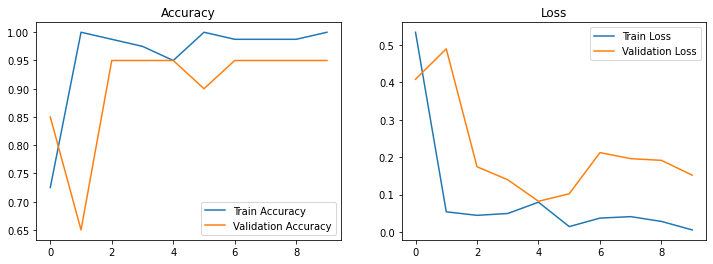

In [72]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [44]:
def predict_handwriting_image(image_path, model, size=(128, 128)):
    image = preprocess_image(image_path, size=size)
    image = image / 255.0
    image = np.stack((image,) * 3, axis=-1) 
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    return f"Dyslexia - {prediction}" if prediction > 0.5 else f"Non-Dyslexia - {prediction}"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction: Dyslexia - [[0.99999976]]


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

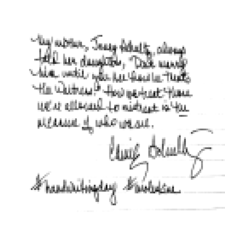

In [79]:
image_path = "./input2.jpg"
result = predict_handwriting_image(image_path, model)
print(f"Prediction: {result}")

matplotlib_image = preprocess_image(image_path)
plt.imshow(matplotlib_image, cmap='gray')
plt.axis('off')